# Linear SVM Classification

The idea behind a Support Vector Machine classifier is to establish a boundary that has the widest separation between the classes. Since the objective of this algorithm is to establish the widest "street" between two classes, instances that are outside the street are not going to afect the location of the boundary. Instead, the boundary between the classes is going to be fully determined by the instaces that are in the limits of the "street" between the two classes.

It is important to keep in mind that Support Vector Machines are sensitive to feature scaling.

## Soft Margin Classification

The condition of having the instances of each class in separate sides of the street is called *hard margin classification*. The problem with establishing a strict condition like that one is that the algorithm would only work properly in linearly separable classes. If only an instance of a class is located near the other class in the feature space, the algorithm will perform poorly. In other words, the hard margin classification is sensitive to outliers.

To avoid this problem, the *soft margin classification* is the one that is generallly used. The idea of the soft margin classification is to limit the amount of instaces that are in the wrong side of the street while keeping the street as wide as possible. The way to control this trade-off in Scikit-Learn is using the hyperparameter C. The algorithm sets a wider street with more margin violations when C is set in a small value, while there are less street violation but a narrower street when C is set high.

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris['data'][:, (2,3)]
y = (iris['target'] == 2).astype(np.float64)

svm_clf = Pipeline((
        ('scaler', StandardScaler()),
        ('linear_svc', LinearSVC(C=1, loss='hinge'))
    ))

svm_clf.fit(X, y)
svm_clf.predict([[5.5, 1.7]])

array([ 1.])

Another way of implemeting a Linear SVM classifier is using the `SVC()` class and setting `kernel='linear`. However, this option is much slower than `LinearSVC` when it comes to large datasets.

Other option is to use the stochastic gradient descent classifier `SGDClassifier` setting `loss=hinge` and `alpha=1/(m*C)`. This method does not converge as fast as `LinearSVC` but is better at handling large datasets that do not fit in memory.

# Nonlinear SVM Classification

Some data sets are not linearly separable. That is, the instances in the feature space cannot be separeted using a straight line. One approach to classify this type of datasets is add more features to the dataset. For example, the new features can be created using polynomial features.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

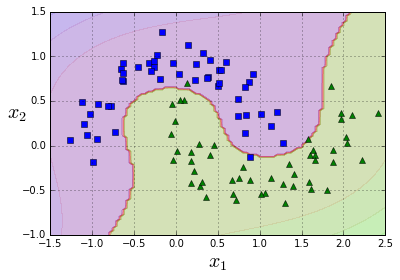

In [3]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

polynomial_svm_clf = Pipeline((
        ('poly_features', PolynomialFeatures(degree=3)),
        ('scaler', StandardScaler()),
        ('svm_clf', LinearSVC(C=10, loss='hinge'))
    
    ))

polynomial_svm_clf.fit(X,y)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

## Polynomial Kernel

Adding polynomial features can be slow because of the multiple feature combinations that may arise when a high degree polynomial is used. To solve this issue when using Support Vector Machines, it is more convenient to use the polynomial kernel. This approach is equilavent to creating more polynomial features, but it is much faster because no combinatorial of the features is involved.

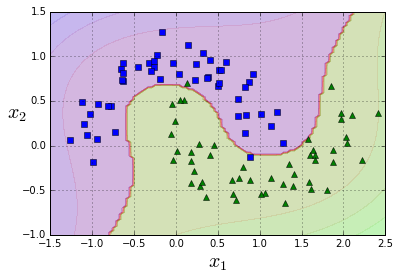

In [4]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline((
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))

    ))

poly_kernel_svm_clf.fit(X,y)

plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

## Adding Similarity Features

Another way of solving the problem of datasets that are not linearly separable is using a similarity function. The idea of the similarity function is to define some landmarks in the feature space. The new features result from calculating the similarity function using the landmark and instance location in the feature space. 

For example, a commonly used similarity function is the Gaussian Radial Basis Function 

$\phi \gamma (\text{x}, l) = \exp(-\gamma \lVert \text{x} - l \rVert^{2})$

Using this function, the new coordinates of instance $x_{i}$ would result in calculating the distance between $x_{i}$ and each landmark. Written in mathematical form, the new coordinates would be $(\phi \gamma (\text{x}, l_{1}), ..., \phi \gamma (\text{x}, l_{k}))$.

An important issue to address with this method is how to define the landmarks to achieve linear separation in the dataset. The simplest approach is to create a landmark at each instance in the dataset. This increases the chances that the dataset is linearly separable since several additional dimensions are created. The problem of creating a lankmark for each feature is that the number of features would be the same as the number of instances. For a large dataset, the number of features is equally large.

## Gaussian RBF Kernel

As mentioned earlier, adding features using as similarity function can be computationally expensive in large datasets. The Gaussian RBF Kernel is commmonly used instead of the similarity function approach, because it obtains result similar to the similarity function without actually adding the features. 

To implement the Gaussian RBF Kernel, the option `kernel='rbf'` must be used. The `gamma` parameter when using this kernel controls the shape of the gaussian bell curve. If `gamma` is set high, the shape would be narrower. Since the gaussian shape is narrower, the influence of each instance is smaller leading to irregular decision boundaries. In the opposite case (`gamma` set to a small value), each instance has a greater influence. This leads to a smoother decision boundary. Taking the latter into account, `gamma` in this model can be considered as a regularization parameter.

**As a rule of thumb**, the linear kernel should be tried first, especially if the training set is large. If the training set is not too large, the RBF kernel should be tried as well.

## Computational Complexity

The `LinearSVC` class is based on the *liblinear* library that implements an optimized algorithm for linear Suppor Vector Machines. This class does not support kernels, but scales linearly with the number of training instaces and the number of features, ie the complexity is $O(m\times n)$. This algorithm can take long if a high precision is required (controlled by the parameter `tol`).

On the other hand, the `SVC` class is implemented using the *libsvm* library that supports the kernel trick. For this implementation, the complexity is between $O(m^2 \times n)$ and $O(m^{3} \times n)$. This square and cubic depedance makes this algorithm slow when the number of instances in a dataset is large. That is why the kernel algorithms are used for complex but small or medium datasets. Also, this algorithm scales well with the number of features, and especially well with sparse features.

# SVM Regression

The idea behind Support Vector Machines for regression is reversing the objective of the Support Vector Machines used for classification. As mentioned earlier, the objective in classification was to achieve the widest possible "street" without instances in it. The objective in regression is to define the narrowest street possible that containns as much instances as possible. 

The width of the steet is defined as the hyperparameter $\epsilon$ of the model. It is said that the model is $\epsilon$-*insensitive* because adding instances inside the margin (or street) does not affect the prediction of the model. 

The class `LinearSVR` regression is the appropiate class for performing linear SVM regressions in Scikit-Learn.

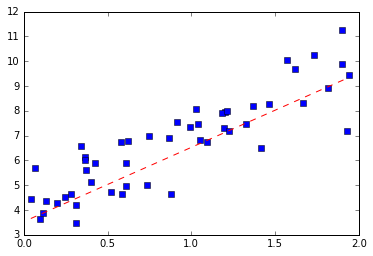

In [7]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5)
svm_reg.fit(X,y)

X_pred = np.linspace(min(X), max(X), 100).reshape(-1, 1)
y_pred = svm_reg.predict(X_pred)

plt.plot(X, y, 'bs')
plt.plot(X_pred, y_pred, 'r--')

To perform a non-linear regression a kernelized SVM model must be used.

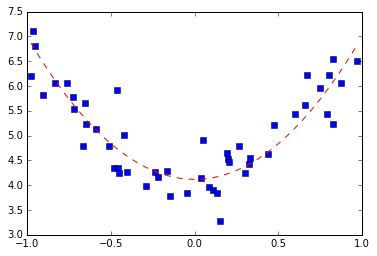

In [16]:
m = 50
X = 2 * np.random.rand(m, 1) -1
y = (4 + 3 * X**2 + np.random.randn(m, 1)/2).ravel()

from sklearn.svm import SVR

svm_poly_reg = SVR(kernel='poly', degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)

X_pred = np.linspace(min(X), max(X), 100).reshape(-1, 1)
y_pred = svm_poly_reg.predict(X_pred)

plt.plot(X, y, 'bs')
plt.plot(X_pred, y_pred, 'r--')

# Under the Hood

## Decision Function and Predictions

The linear SVM classifier uses the function

$\textbf{w}^{T} \cdot \textbf{x} + b$

where $\textbf{w}$ is the feature weights vector and $b$ the bias term. If the function is less than 0, the class is negative and if it is greater or equal than 0 the class is predicted positive. The decision boundary is a hyperplane where the decision function is equal to zero. The idea of training an SVM is to find the vector $\textbf{w}$ that creates the widest street possible with the least amount of margin violations. 

## Training Objective

The slope of the decision function corresponds to the norm of the feature weight vector $\lVert \textbf{w}\rVert$. Because the slope depends on the norm of $\textbf{w}$, the smaller the weight vector, the larger the margin. This is why it is desirable to minimize $\lVert \textbf{w}\rVert$.

On the other hand, the amount of training instances that violate the margins should be reduced. In other words, the decision function should be greater than 1 for positive instances and -1 for negative instances. This constrain can be expressed in a more succint way with the expression

$t^{(i)}(\textbf{w}^{T} \cdot \textbf{x} + b) \geq 1 $

where $t^{(i)} = -1$ for negative instances and $t^{(i)} = 1$ for positive instances.

Taking everythin into account, the classifier objective for a **hard margin classifier** is:
+ Minimize $\frac{1}{2}\textbf{w}^{T}\cdot \textbf{w}$ 
+ Subject to $t^{(i)}(\textbf{w}^{T} \cdot \textbf{x} + b) \geq 1 $. 

It has to be noted that it is $\frac{1}{2}\textbf{w}^{T}\cdot \textbf{w}$ instead of $\lVert \textbf{w}\rVert$ that is minimized. The first expression is chosen over the second one because the former has a simpler derivative than the latter. The minimization does not change since the minimum of the first expression is also a minimum of the second.

To achieve write the objective for a **soft margin classifier**, an additional variable $\xi^{(i)} \leq 0$ for each instance is introduced. $\xi^{(i)}$ defines how much the instance $i$ can violate the margin. Now, the objective is to make $\frac{1}{2}\textbf{w}^{T}\cdot \textbf{w}$ and $\xi^{(i)}$ as small as possible. This two objectives are in conflict between each other since the former increases the margin as much as possible while the latter tries to reduce the margin violation of each instance. To define a trade-off between the two objectives, the hyperparameter C is defined.  With this new hyperparameter the objectives for the soft margin classifier are:

+ Minimize  $\frac{1}{2}\textbf{w}^{T}\cdot \textbf{w} + C \sum_{i=1}^{m}\xi^{(i)}$
+ Subject to $t^{(i)}(\textbf{w}^{T} \cdot \textbf{x} + b) \geq 1 - \xi^{(i)}$ and $\xi^{(i)} \geq 0$

